# 1) Data Preprocessing

In [ ]:
from klines_managers import klines_ccxt

instruments =  ["ccxt_kucoin__BTC-USDT"]
timeframes = ["1h"]

kline_manager = klines_ccxt.KlinesManagerCCXT()
test = kline_manager.load_ohlcvs(instruments = instruments,
                                    timeframes = timeframes,
                                    since = "2020-01-01 00:00:00",
                                    limit = 1000)

In [ ]:
from signal_managers import indicators
df = test["ccxt_kucoin__BTC-USDT"]["1h"].copy()
df = indicators.calc_tides(df)

In [ ]:
df

In [4]:
from utils import pickle_helper

pickle_helper.pickle_this(df, pickle_name = "df_tide_test", path = "./database/backtest_dfs/")

# 2) Backtest

In [5]:
from utils import pickle_helper

df = pickle_helper.pickle_this(pickle_name = "df_tide_test", path = "./database/backtest_dfs/")
df


,open,high,low,close,volume,close_time,tide,ebb,flow
datetime,,,,,,,,,
2018-11-25 16:00:00,3886.678607,3903.648904,3835.158247,3875.647378,24.080719,1.543162e+09,NaN,NaN,NaN
2018-11-25 17:00:00,3882.521407,3891.388154,3816.986907,3849.141652,21.726807,1.543165e+09,NaN,NaN,NaN
2018-11-25 18:00:00,3859.873602,3895.840831,3842.289291,3873.965860,10.762191,1.543169e+09,NaN,NaN,NaN
2018-11-25 19:00:00,3864.252323,4019.285405,3858.893570,3924.100347,50.699665,1.543172e+09,NaN,NaN,NaN
2018-11-25 20:00:00,3935.724843,4163.629852,3913.719395,4064.823624,87.334735,1.543176e+09,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-08-21 02:00:00,26146.200000,26159.700000,26079.300000,26096.700000,30.048178,1.692583e+09,-1.0,26128.65,26080.65
2023-08-21 03:00:00,26096.700000,26108.800000,26072.000000,26091.400000,15.693983,1.692587e+09,-1.0,26128.65,26085.35
2023-08-21 04:00:00,26091.500000,26091.500000,26041.600000,26058.800000,51.110190,1.692590e+09,-1.0,26128.65,26085.65


In [ ]:
# check predictive power of tide
# df["tide_fast"]=df["tide_fast"].shift(-1).fillna(method="ffill")

100%|██████████| 40639/40639 [00:00<00:00, 588036.31it/s]


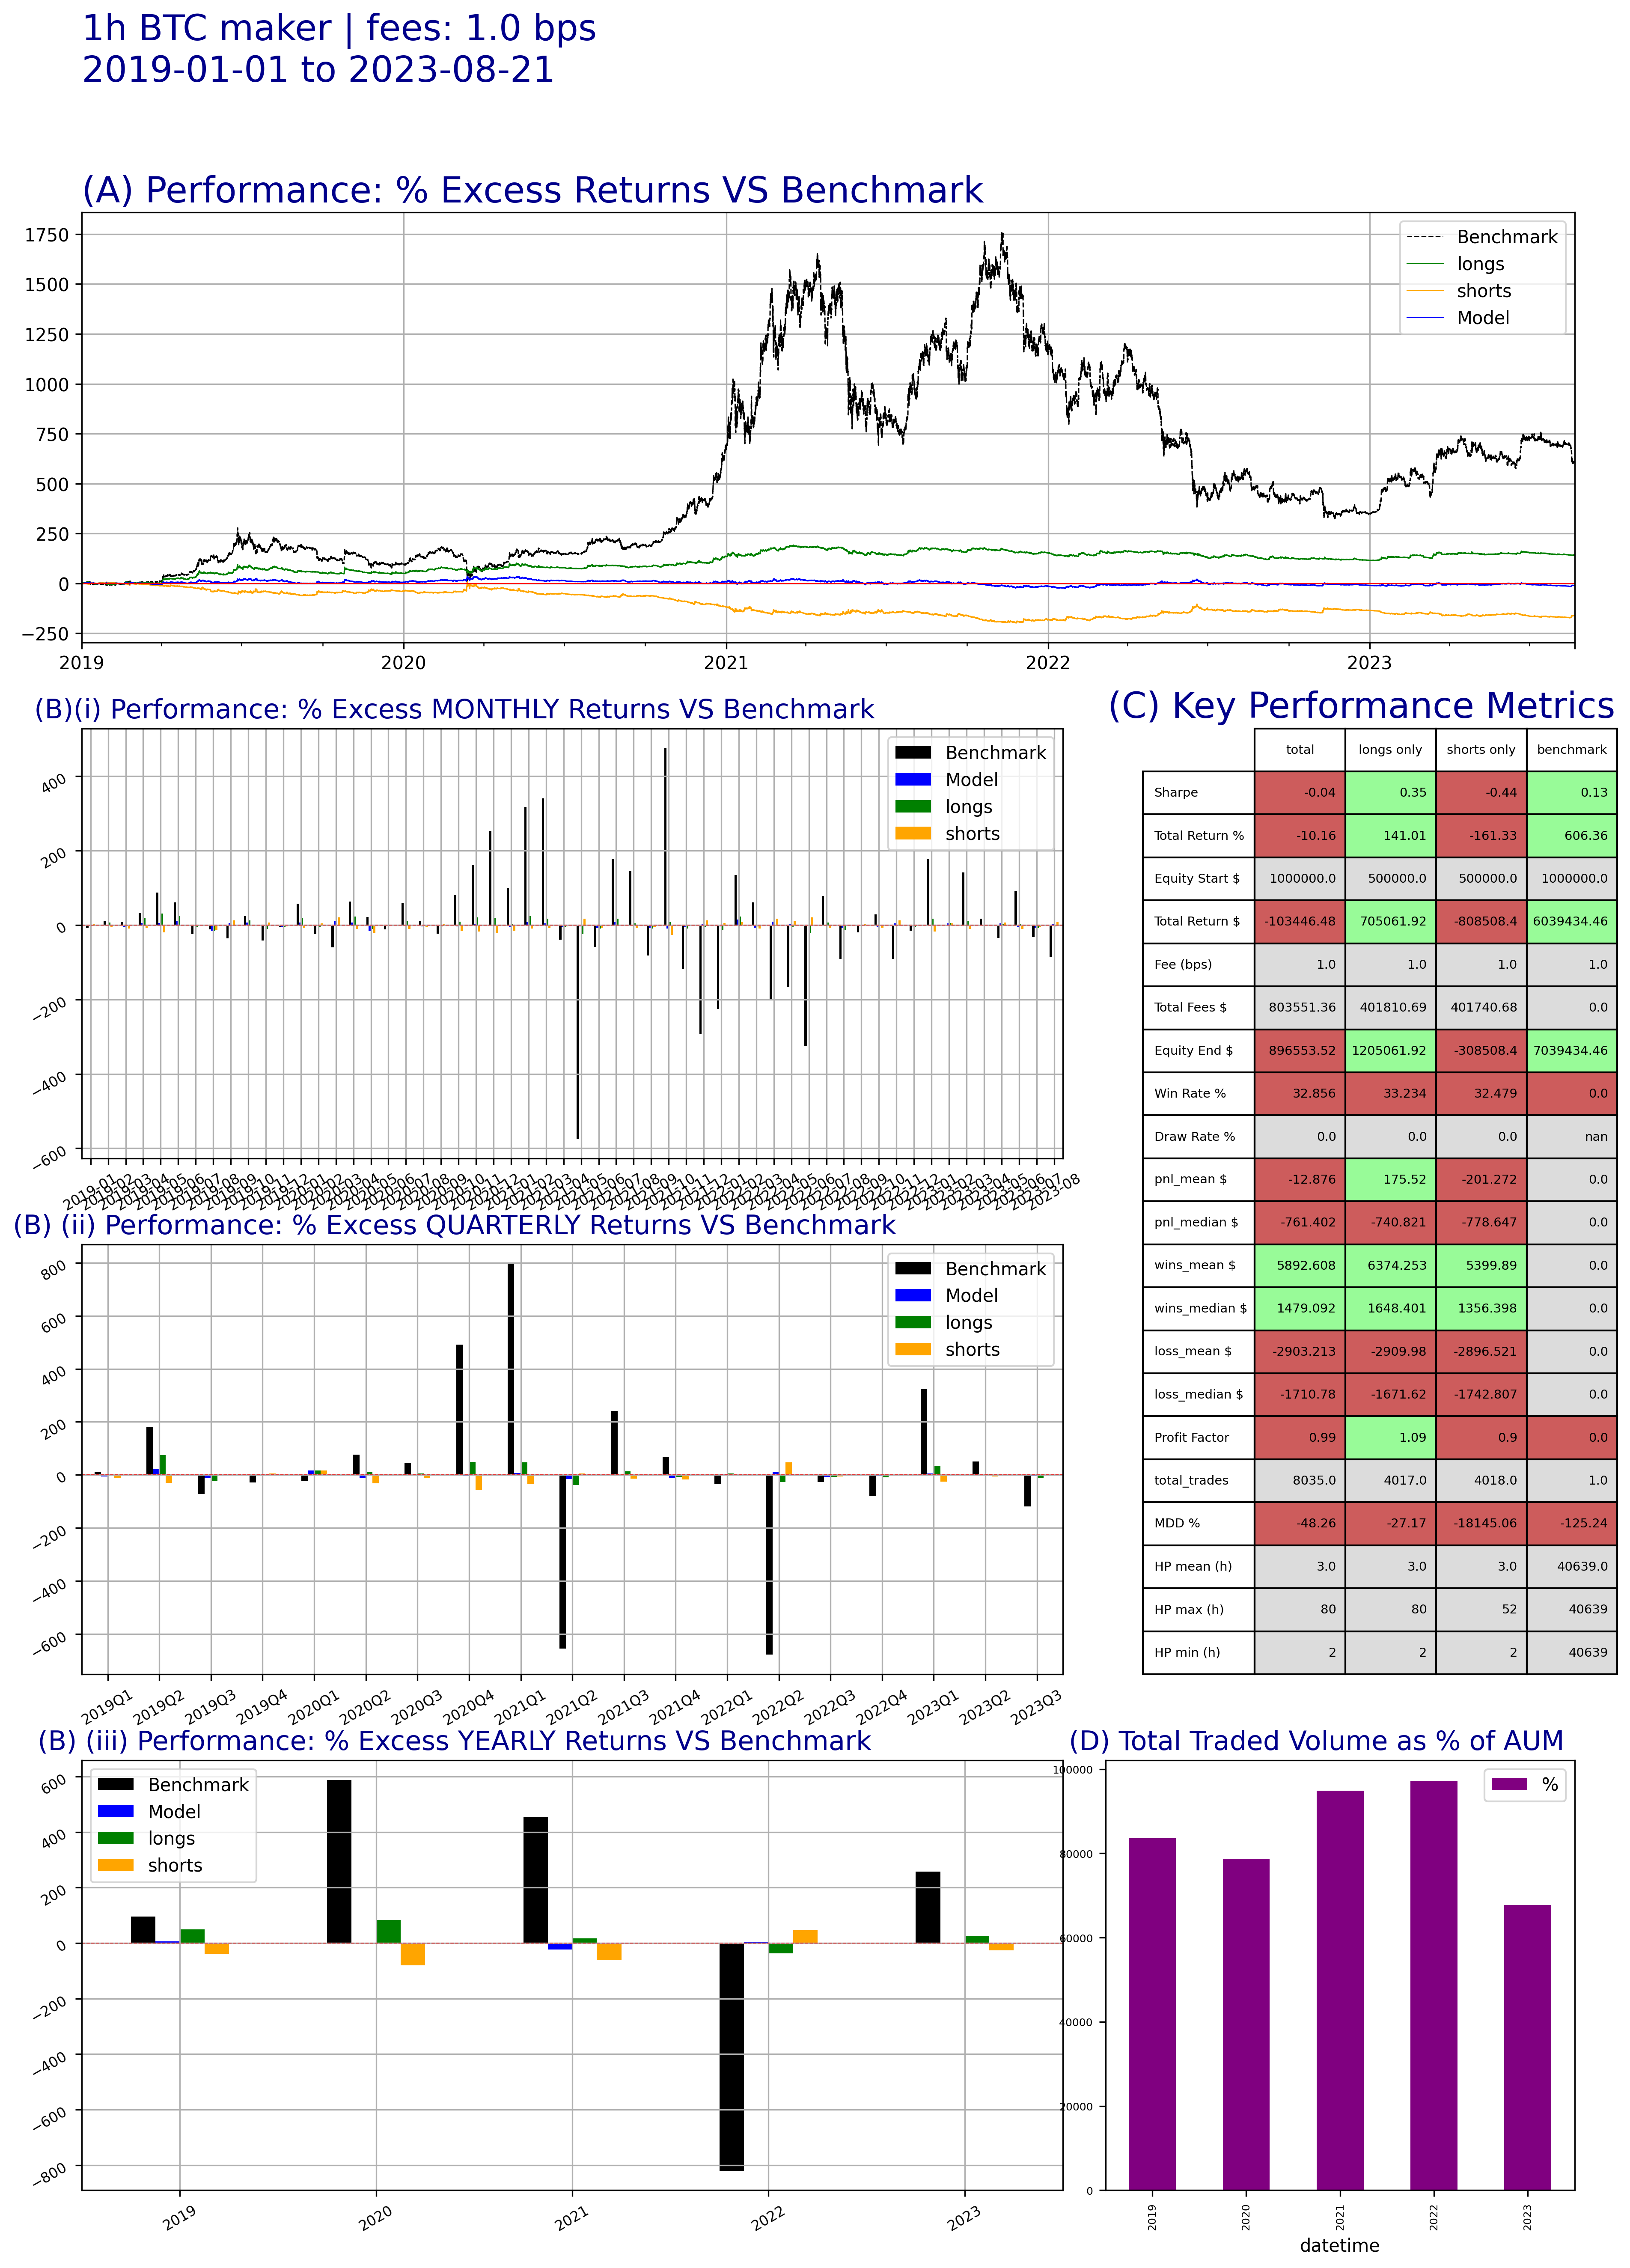

In [7]:
import importlib
from performance_analytics import metrics
importlib.reload(metrics)
from performance_analytics import backtest_plot
importlib.reload(backtest_plot)
from backtesters import backtest
importlib.reload(backtest)

# ============================
# Backtest parameters
# ============================
signals = [f"tide"]



fee = 0.0001
# fee = 0
slippage = 0.0

min_holding_period = 0
max_holding_period = 1e6

long_equity = 5e5
long_notional=5e5
short_equity = 5e5
short_notional= 5e5

signal_function="default"
figsize = (20,15) #(20,29) # width, height
# figsize = (20,30)
# window =["2020-11-02","2022-08-23"] # - 0th backtest
window =["2019-01-01","2023-12-31"] 
model_name= "Trend_Following"
# window =["2022-06-01","2023-12-31"] 
# model_name = "Mean_Reversion"


tradable_times = [["00:05", "23:50"]]
closing_session_times= [["23:50", "00:00"]]



timeframe = "1h"
sig_timeframe = f"1h"
kline_to_trade = f"close"
volume_to_trade= f"volume"



title = f"{timeframe} BTC maker | fees: {fee*1e4} bps"
file_name = f"{timeframe} BTC Tide"
# signal = "ES_USD_close_sig" 
# window = ["2021-01-01","2021-12-31"] 
df_sig = df.copy()
df_trade = df_sig[window[0]:window[1]].copy()

df_trade[["sig"]] = df_trade[signals]
signals = ["sig"]
df_backtested,df_trades,df_summary = backtest.backtest(model_name= model_name,
                                                       df0=df_trade,
                                                       timeframe=timeframe,
                                                       kline_to_trade=kline_to_trade,
                                                       volume_to_trade = volume_to_trade,
                                                       tradable_times = tradable_times,
                                                       closing_session_times = closing_session_times,
                                                       position_sizing_to_trade=None,
                                                       min_holding_period=min_holding_period/int(timeframe[:-1]),
                                                       max_holding_period=max_holding_period/int(timeframe[:-1]),
                                                       fee=fee,
                                                       slippage=slippage,
                                                       long_equity = long_equity,
                                                       short_equity = short_equity,
                                                       long_notional=long_notional,
                                                       short_notional=short_notional,
                                                       signals=signals, 
                                                       signal_function=signal_function, 
                                                       figsize=figsize, # width, height
                                                       show_B=True,
                                                       show_LS=True,
                                                       title=title,
                                                       file_name=file_name,
                                                       plots="ppt",
                                                       diagnostics_verbose=False,
                                                       trail_SL = None,
                                                       trail_TP = None,
                                                       trail_increment = None,
                                                       N=365*8
                                                       )

### i) Plotly Analyses

In [ ]:

import importlib
from performance_analytics import plotly_studies
importlib.reload(plotly_studies)


# window = ["2022-01-01","2022-12-31"] 
window = ["2023-08-01","2023-12-31"]

timeframe = "1h"

ohlc = {"instrument":"BTCUSDT",
        "open":f"open",
        "high":f"high",
        "low":f"low",
        "close":f"close",
        "up_color":'rgb(14,203,129)',
        "down_color":'rgb(233,67,89)',
        "opacity":1}


cols_to_plot = [["cum_A_pnl", "cum_S_pnl","cum_L_pnl"],
                [ohlc,'L_entry_price','L_exit_price','S_entry_price','S_exit_price',],
                ['tide_fast__scatter'],
                ]


subplot_titles = ["Long/short/total cumulative PNL $",f"BTCUSD", "tide"]
# subplot_titles = ["Long/short/total cumulative PNL $", f"{instruments[0]}", "signal", 'size']#"ES1!"]
row_heights = [1,2,3]
ps = plotly_studies.build(cols_to_plot = cols_to_plot,
                          row_heights = row_heights,
                          height=1000,
                          width=1500,
                         resampler=False, 
                         publish=True,
                         output_path= "./backtests/",
                         output_name = "BTC model",
                         subplot_titles = subplot_titles,
                         verbose=True)
ps.plot(df_backtested[window[0]:window[1]])

In [ ]:
df_backtested[window[0]:window[1]]

In [ ]:
df_backtested

# 3) Hypothesis 1
Use tide strengths as measure for tide

In [ ]:
# from utils import pickle_helper
# pickle_helper.pickle_this(df, "df_rolling_sr_debugging", path = "./signal_managers/debug/")

In [ ]:
from utils import pickle_helper
# df = pickle_helper.pickle_this(pickle_name= "debugdf_backtested", path = "./backtesters/")
df = pickle_helper.pickle_this(pickle_name = "df_rolling_sr_debugging", path = "./signal_managers/debug/")
# df.rename(columns={"tide_fast":"tide", "ebb_fast":"ebb", "flow_fast":"flow"}, inplace=True)

from signal_managers.indicators import calc_tide_strengths

tp_position_dict = {"TP1": {"long":{"lookback":3, "qtl": 0.3}, 
                            "short": {"lookback":3, "qtl":0.3}
                            },
                    "TP2": {"long":{"lookback":6, "qtl": 0.66}, 
                            "short": {"lookback":6, "qtl":0.66}
                            },
                    "TP3": {"long":{"lookback":9, "qtl": 0.99}, 
                            "short": {"lookback":9, "qtl":0.99}
                            }
                    }


df = calc_tide_strengths(df, penalty = 1, tp_position_dict = tp_position_dict)

In [ ]:
# pickle_helper.pickle_this(data=df, pickle_name = "df_tide_0", path = "./signal_managers/debug/")

Hypothesis question

So now that we have TPs and SLs, and tide durations, what do we do? 

We can further derive tide duration qtls for overheated tides, and then use that to determine the probability of overheating/tide flipping.

We can also use the qtls to determine the probability of a tide flipping, and then use that to determine the probability of overheating.

How would the probability be calculated?

So a duration that hits a certain duration qtl (say 90%) would have a 90% chance of overheating.

Now that we have all these features, we can use them to enter a long or short

so how do enter a position? 

NEED TO PLOT OUT TPs SLs, DURATIONS on graph with closing price! then can decide on how trades should be taken! 

In [ ]:
df.filter(regex="tide_long")

## a) Plotly Analyses

In [ ]:

import importlib
from performance_analytics import plotly_studies
importlib.reload(plotly_studies)


# window = ["2022-01-01","2022-12-31"] 
window = ["2023-08-07 00:00:00","2023-08-10 12:00:00"]

timeframe = "1h"

ohlc = {"instrument":"BTCUSDT",
        "open":f"open",
        "high":f"high",
        "low":f"low",
        "close":f"close",
        "up_color":'rgb(14,203,129)',
        "down_color":'rgb(233,67,89)',
        "opacity":1}


cols_to_plot = [["cum_L_pnl"],
                [ohlc,'L_entry_price','L_exit_price','S_entry_price','S_exit_price',
                 "tide_long_TP1", "tide_long_SL1",
                 "tide_long_TP2", "tide_long_SL2"],
                 ["tide_dur","tide_long_TP1_t","tide_long_SL1_t", "tide_long_TP2_t","tide_long_SL2_t"],
                ['tide__scatter'],
                ]


subplot_titles = ["Long/short/total cumulative PNL $",f"BTCUSD", "tide_t", "tide"]
# subplot_titles = ["Long/short/total cumulative PNL $", f"{instruments[0]}", "signal", 'size']#"ES1!"]
row_heights = [1,3,2,2]
ps = plotly_studies.build(cols_to_plot = cols_to_plot,
                          row_heights = row_heights,
                          height=1000,
                          width=1500,
                         resampler=False, 
                         publish=True,
                         output_path= "./backtests/",
                         output_name = "BTC model",
                         subplot_titles = subplot_titles,
                         verbose=True)
ps.plot(df[window[0]:window[1]])

## b) Backtest

In [ ]:
from utils import pickle_helper
# df = pickle_helper.pickle_this(pickle_name= "debugdf_backtested", path = "./backtesters/")
df = pickle_helper.pickle_this(pickle_name = "df_tide_0", path = "./signal_managers/debug/")
# df.rename(columns={"tide_fast":"tide", "ebb_fast":"ebb", "flow_fast":"flow"}, inplace=True)

from signal_managers.indicators import calc_tide_strengths

tp_position_dict = {"TP1": {"long":{"lookback":3, "qtl": 0.3}, 
                            "short": {"lookback":3, "qtl":0.3}
                            },
                    "TP2": {"long":{"lookback":6, "qtl": 0.66}, 
                            "short": {"lookback":6, "qtl":0.66}
                            },
                    "TP3": {"long":{"lookback":9, "qtl": 0.99}, 
                            "short": {"lookback":9, "qtl":0.99}
                            }
                    }


df = calc_tide_strengths(df, penalty = 1, tp_position_dict = tp_position_dict)

In [ ]:
import importlib
from performance_analytics import metrics
importlib.reload(metrics)
from performance_analytics import backtest_plot
importlib.reload(backtest_plot)
from backtesters import backtest
importlib.reload(backtest)

# ============================
# Backtest parameters
# ============================
signals = df.columns[-63:]



fee = 0.0001
# fee = 0
slippage = 0.0

min_holding_period = 0
max_holding_period = 1e6

long_equity = 5e5
long_notional=5e5
short_equity = 5e5
short_notional= 5e5

signal_function="strengths"
figsize = (20,15) #(20,29) # width, height
# figsize = (20,30)
# window =["2020-11-02","2022-08-23"] # - 0th backtest
window =["2020-01-01","2023-12-31"] 
model_name= "Trend_Following"
# window =["2022-06-01","2023-12-31"]
# model_name = "Mean_Reversion"


tradable_times = [["00:05", "23:50"]]
closing_session_times= [["23:50", "00:00"]]



timeframe = "1h"
sig_timeframe = f"1h"
kline_to_trade = f"close"
volume_to_trade= f"volume"



title = f"{timeframe} BTC spot | fees: {fee*1e4} bps"
file_name = f"{timeframe} BTC Tide"

df_sig = df.copy()
df_trade = df_sig[window[0]:window[1]].copy()
signals = df_trade.columns
df_backtested,df_trades,df_summary = backtest.backtest(model_name= model_name,
                                                       df0=df_trade,
                                                       timeframe=timeframe,
                                                       kline_to_trade=kline_to_trade,
                                                       volume_to_trade = volume_to_trade,
                                                       tradable_times = tradable_times,
                                                       closing_session_times = closing_session_times,
                                                       position_sizing_to_trade=None,
                                                       min_holding_period=min_holding_period/int(timeframe[:-1]),
                                                       max_holding_period=max_holding_period/int(timeframe[:-1]),
                                                       fee=fee,
                                                       slippage=slippage,
                                                       long_equity = long_equity,
                                                       short_equity = short_equity,
                                                       long_notional=long_notional,
                                                       short_notional=short_notional,
                                                       signals=signals, 
                                                       signal_function=signal_function, 
                                                       figsize=figsize, # width, height
                                                       show_B=True,
                                                       show_LS=True,
                                                       title=title,
                                                       file_name=file_name,
                                                       plots=False,
                                                       diagnostics_verbose=False,
                                                       trail_SL = None,
                                                       trail_TP = None,
                                                       trail_increment = None,
                                                       N=365*8
                                                       )

print(df_summary.iloc[0,:])

## c) Genetic Algorithm 1 parent

In [ ]:
from signal_managers import tide_genetic

tp_position_list = tide_genetic.init_tp_position_parameter_population()
df0 = tide_genetic.initialise_parent()
tide_parameters_to_test = {"sensitivity":40,
                           "threshold":10,
                            "windows":[10,20,67],
                            "SL_penalty":1,
                            "TPs": tp_position_list[0],
                           }
sharpe_df, best_df = tide_genetic.evaluate_population(df0,parameters = tide_parameters_to_test, generations=20)

In [ ]:
from signal_managers import tide_genetic

tp_position_list = tide_genetic.init_tp_position_parameter_population()
df0 = tide_genetic.initialise_parent()
tide_parameters_to_test = {"sensitivity":40,
                           "threshold":10,
                            "windows":[24,36,72],
                            "SL_penalty":1,
                            "TPs": tp_position_list[0],
                           }
sharpe_df, best_df, best_parameter = tide_genetic.evaluate_population(df0,parameters = tide_parameters_to_test, generations=20)

In [ ]:

from backtesters import backtest
from tqdm import tqdm
from tqdm import trange
from time import sleep

from signal_managers import tide_genetic




# df = pickle_helper.pickle_this(pickle_name = "df_rolling_sr_debugging", path = "./signal_managers/debug/")
# instruments =  ["ccxt_kucoin__BTC-USDT"]
# timeframes = ["1h"]



tide_parameters_to_test = {"sensitivity":[10,20,30,40,50,60,70,80,90,95,99],
                           "thresholds":[10,20,30,40,50,60,70,80,90,95,99],
                            "windows":[[10,20,67],[10,20,67,134],[10,20,67,134,268],[10,20,67,134,268,536],[10,20,67,134,268,536,1072]],
                            "TPs": tp_position_list,
                            "SL_penalty":[1,2,3,4,5,6,7,8,9,10],
                           }
sharpe_results = {}

for s in tqdm(tide_parameters_to_test["sensitivity"]):
    for t in tide_parameters_to_test["thresholds"]:
        for w in tide_parameters_to_test["windows"]:
            for TPs in tide_parameters_to_test["TPs"]:
                for sl in tide_parameters_to_test["SL_penalty"]:

                    df0 = tide_genetic.initialise_parent()
                    tide_parameters_to_test = {"sensitivity":s, 
                                            "threshold":t,
                                                "windows":w,
                                                "SL_penalty":sl,
                                                "TPs": TPs,
                                            }
                    df, best_df, best_parameters = tide_genetic.evaluate_population(df0,parameters = tide_parameters_to_test, generations=20)

                    # Done with one generation
                    # t.set_description(f"Iteration: {i} (sensitivity: {s})--> Sharpe: {sharpe}")
                    # t.refresh() # to show immediately the update
                    # sleep(0.00) # to avoid flickering
    

# Hypothesis 1b: Macro factor: SNP zscore

## a) Load data and calc tide

In [ ]:
import pandas as pd
from klines_managers import klines_ccxt

timeframe_to_trade = "1h"


instruments =  ["ccxt_kucoin__BTC-USDT",
                 "ccxt_currencycom__US500",
                 "ccxt_currencycom__DXY",
                 "ccxt_currencycom__Gold",
                 "ccxt_currencycom__Oil - Crude",
                  "ccxt_currencycom__NVDA",
                   "ccxt_currencycom__UVXY" ]
timeframes = ["1h"]

kline_manager = klines_ccxt.KlinesManagerCCXT()
klines_dict = kline_manager.load_ohlcvs(instruments = instruments,
                                        timeframes = timeframes,
                                        since = "2018-01-01 00:00:00",
                                        limit = 1000, update=False)


# Resample from 1hr --> 2h, 3h, 4h, 6h, 12h, 24h, 
from signal_managers import resampler
from signal_managers import indicators

resample_to_list = ["2h", "3h", "4h", "6h", "12h", "24h"][0:3]
first_timeframe = "1h"

print(klines_dict.keys())
print(klines_dict['ccxt_kucoin__BTC-USDT'].keys())
# resample_to_list = ["15m", "20m", "30m", "60m"]
# first_timeframe = "5m"
for instrument,instrument_dict in klines_dict.items():
    # print(f"\n{instrument}\n")
    for resample_to in resample_to_list:
        df = instrument_dict[first_timeframe].copy()
        window = int(int(resample_to[:-1])/int(first_timeframe[:-1]))
        # print(f"Resampling {first_timeframe} to {resample_to} --> window: {window}")
        if "m" in resample_to:
            resample_to_formatted = resample_to[:-1]+"T"
        else:
            resample_to_formatted = resample_to
        df_resampled = resampler.calc_klines_resample(df,window=window, resample_to=resample_to_formatted)
        # print(df_resampled.columns)
        klines_dict[instrument][resample_to] = df_resampled


from signal_managers.indicators import calc_tide_strengths
from signal_managers import tide_genetic

print(klines_dict.keys())
print(klines_dict['ccxt_kucoin__BTC-USDT'].keys())
# generate tides for each instruments
instrument_to_trade = "ccxt_kucoin__BTC-USDT"
timeframe_to_trade = "1h"
for instrument in klines_dict.keys():
    for timeframe in klines_dict[list(klines_dict.keys())[0]]:
        df = klines_dict[instrument][timeframe]
        df = indicators.calc_tides(df,suffix="")
        df=df.dropna()
        from signal_managers import tide_genetic

        # Initialise parent
        tp_position_list = tide_genetic.init_tp_position_parameter_population()
        df0 = tide_genetic.initialise_parent(df)
        df0 = calc_tide_strengths(df0, penalty = 1, tp_position_dict = tp_position_list[0])
        features = ['tide', 'ebb', 'flow', 'sig'] + list(df0.copy().filter(regex="tide").columns)[:-1]
        features = list(set(features))

        tide_parameters_to_test = {"sensitivity":40,
                                "threshold":10,
                                    "windows":[24,36,72],
                                    "SL_penalty":1,
                                    "TPs": tp_position_list[0],
                                }
        sharpe_df, best_df, best_parameter, best_sharpe = tide_genetic.evaluate_population(df0,parameters = tide_parameters_to_test, generations=10)
        # Perform genetic propagation
        best_df[features] = best_df[features].copy().fillna(method='ffill').dropna()
        klines_dict[instrument][timeframe] = best_df
        
        # Join into one DF
        if instrument == instrument_to_trade and timeframe == timeframe_to_trade:
            df_trade = best_df.copy() 

        else:
            df["sharpe"] = best_sharpe["sharpe"].iloc[0]
            df_trade = pd.merge(df_trade, best_df[features].add_prefix(f"{timeframe}_{instrument.split('__')[-1]}_"), left_index=True, right_index=True, how="left")
    


In [ ]:
df_trade[all_tide_features]

## b) Perform genetic optimiser and plot macro tides 

In [ ]:
from utils import pickle_helper
# pickle_helper.pickle_this(df_trade, 'df_macros_trade', path='./signal_managers/debug/')
# pickle_helper.pickle_this(klines_dict, 'klines_dict', path='./signal_managers/debug/')

df =  pickle_helper.pickle_this(pickle_name='df_macros_trade', path='./signal_managers/debug/')
klines_dict = pickle_helper.pickle_this(pickle_name='klines_dict', path='./signal_managers/debug/')

In [ ]:
df.filter(regex="tide")
instruments =  ["ccxt_currencycom__US500",
                 "ccxt_currencycom__DXY",
                 "ccxt_currencycom__Gold",
                 "ccxt_currencycom__Oil - Crude",
                  "ccxt_currencycom__NVDA",
                   "ccxt_currencycom__UVXY" ]
timeframes = klines_dict[instruments[0]].keys()
macro_features_selected = [f"{timeframe}_{feature.split('__')[-1]}_tide" for feature in instruments for timeframe in timeframes]
all_tide_features = ['tide']+macro_features_selected

## c) Macro predictor using tides

### i) Build label: tide.shift(-1)

In [ ]:
df['label'] = df['tide'].shift(-1).fillna(method='ffill').fillna(-1)

In [ ]:
df['label']

### ii) Data windowing and Model fit

In [ ]:
# pip install catboost

In [ ]:
from utils import pickle_helper
# pickle_helper.pickle_this(data=df, pickle_name='df', path='./signal_managers/debug/')
df = pickle_helper.pickle_this(pickle_name='df', path='./signal_managers/debug/')
klines_dict = pickle_helper.pickle_this(pickle_name='klines_dict', path='./signal_managers/debug/')

In [ ]:
df.filter(regex="tide")
instruments =  ["ccxt_currencycom__US500",
                 "ccxt_currencycom__DXY",
                 "ccxt_currencycom__Gold",
                 "ccxt_currencycom__Oil - Crude",
                  "ccxt_currencycom__NVDA",
                   "ccxt_currencycom__UVXY" ]
timeframes = klines_dict[instruments[0]].keys()
macro_features_selected = [f"{timeframe}_{feature.split('__')[-1]}_tide" for feature in instruments for timeframe in timeframes]
all_tide_features = ['tide']+macro_features_selected

In [ ]:
from catboost import Pool

import numpy as np
train_window = [df.index[0], df.index[-1]]

# df=df.filter(regex="(1h)|(label)")
# df.dropna(inplace=True)
# df= df.filter(regex="(1h)|(label)")
df = df.copy()
timeframe = ""
# features = all_tide_features[1:] #
features = list(df.filter(regex="tide"))
cat_features = all_tide_features
print(f"FEATURES: {features}")
#  Ensure cat_features are int

df[cat_features] = df[cat_features].fillna(method="ffill")
df.dropna(subset=cat_features,inplace=True)
df[cat_features]=df[cat_features].fillna(-1).astype(int)
labels = ['label'] 

df_train = df[train_window[0]:train_window[1]].copy()
df_train_full = df[train_window[0]:train_window[1]].copy()
df_val = df[train_window[0]:train_window[1]].copy()
df_test = df[train_window[0]:train_window[1]].copy()

print(f"TOTAL window: {df.index[0]} ----> {df.index[-1]}, len: {len(df)}")
print(f"TRAIN window: {df_train.index[0]} ----> {df_train.index[-1]}, len: {len(df_train)}")
print(f"TOTAL TRAIN window: {df_train_full.index[0]} ----> {df_train_full.index[-1]}, len: {len(df_train_full)}")
print(f"VAL window: {df_val.index[0]} ----> {df_val.index[-1]}, len: {len(df_val)}")
print(f"TEST window: {df_test.index[0]} ----> {df_test.index[-1]}, len: {len(df_test)}")
print(f"VAL/TRAIN: {len(df_val)/(len(df_val)+len(df_train))}")
print(f"\ncaat features:\n{cat_features}")
print(f"\nlabels:\n{labels}\nfeatures: \n{features}")


# %matplotlib widget
import matplotlib.pyplot as plt
fig, axs = plt.subplot_mosaic("AAA;BCD")
df_train[f"{timeframe}close"].plot(ax=axs["A"])
df_val[f"{timeframe}close"].plot(ax=axs["A"])
df_test[f"{timeframe}close"].plot(ax=axs["A"])
df_train[labels].hist(ax=axs["B"], color="blue")
df_val[labels].hist(ax=axs["C"],color="orange")
df_test[labels].hist(ax=axs["D"],color="green")
# df[test_window[1]:][labels].hist(ax=axs["D"],color="green")
# label_train = df_train[labels].value_counts()

train_dataset = Pool(df_train[features],df_train[labels], cat_features=cat_features)
train_full_dataset = Pool(df_train_full[features],df_train_full[labels], cat_features=cat_features)
val_dataset = Pool(df_val[features],df_val[labels],cat_features=cat_features)
test_dataset = Pool(df_test[features],df_test[labels],cat_features=cat_features)

# 

In [ ]:
# from catboost import CatBoostClassifier, Pool

# model = CatBoostClassifier(task_type="GPU",iterations=iterations)
# model.fit(X=df_train[features], y=df_train[labels],cat_features = cat_features, verbose=False,plot=True)
from catboost import CatBoostClassifier
import time
t0 = time.time()
model = CatBoostClassifier(task_type="CPU",iterations=10)
# grid = {'iterations': [100, 150, 200],
#         'learning_rate': [0.03, 0.1],
#         'depth': [2, 4, 6, 8],
#         'l2_leaf_reg': [0.2, 0.5, 1, 3]}

# model.grid_search(grid, train_dataset)
model.fit(train_dataset, eval_set=val_dataset, verbose=False,plot=True)

t1 = np.round(time.time()-t0,3)
print(f"train duration: {t1}s")

In [ ]:
# %matplotlib widget
from sklearn.metrics import accuracy_score, f1_score
# import shap
import pandas as pd
cat_features=[]

def calc_accuracy(model, features,cat_features, labels, df_train,df_test, feature_importances=False):
    train_y_pred = model.predict(df_train[features])
    model_reports = {}
    model_reports["IST Acc"] =  accuracy_score(df_train[labels], train_y_pred)
    model_reports["IST F1"] = f1_score(df_train[labels], train_y_pred,average="weighted")
    
    train_y_pred = model.predict(df_train[features])
    train_y_probs = model.predict_proba(df_train[features])
    
    test_y_pred = model.predict(df_test[features])
    test_y_probs = model.predict_proba(df_test[features])
    
    
    model_reports["OST Acc"] =  accuracy_score(df_test[labels], test_y_pred)
    model_reports["OST F1"] = f1_score(df_test[labels], test_y_pred,average="weighted")
    
    if feature_importances:
        df_fi = pd.DataFrame(model.feature_importances_, index=df_train[features].columns, ).sort_values(by=0,ascending=False)
        fi_top = df_fi[df_fi>1].dropna()
        print(fi_top)
        fi_bot = df_fi[df_fi<=1].dropna()
        print(fi_bot)
        
        print(model_reports)
#         explainer = shap.TreeExplainer(model)
#         shap_values = explainer.shap_values(Pool(df_train[features], df_train[labels], cat_features=cat_features))
# #         shap.summary_plot(shap_values, df_train[features], plot_type="bar")
#         shap.summary_plot(shap_values, df_train[features])
    return model_reports


In [ ]:
model_reports = calc_accuracy(model, features,cat_features, labels, df_train,df_test,feature_importances=True)

number_of_labels = 2


df_to_backtest = df.copy() 
target_signal = "tide"

y_pred = model.predict(df[features])
y_probs = model.predict_proba(df[features])
print(y_pred)
df_to_backtest["Y"] = y_pred
if number_of_labels >2:
    
    df_to_backtest["p_u"] = y_probs[:,2]
    df_to_backtest["p_s"] = y_probs[:,1]
    df_to_backtest["p_d"] = y_probs[:,0]
    signals = ["signal","p_u","p_s","p_d","Y"]
else: 
    df_to_backtest["p"] = y_probs[:,-1]
    signals = ["signal","p","Y"]
df_to_backtest["signal"] = df_to_backtest[target_signal]


### iii) rolling walk forward

In [ ]:
from utils import pickle_helper
# pickle_helper.pickle_this(data=df, pickle_name='df', path='./signal_managers/debug/')
df = pickle_helper.pickle_this(pickle_name='df', path='./signal_managers/debug/')
klines_dict = pickle_helper.pickle_this(pickle_name='klines_dict', path='./signal_managers/debug/')

In [ ]:
df.filter(regex="tide")
instruments =  ["ccxt_currencycom__US500",
                 "ccxt_currencycom__DXY",
                 "ccxt_currencycom__Gold",
                 "ccxt_currencycom__Oil - Crude",
                  "ccxt_currencycom__NVDA",
                   "ccxt_currencycom__UVXY" ]
timeframes = klines_dict[instruments[0]].keys()
macro_features_selected = [f"{timeframe}_{feature.split('__')[-1]}_tide" for feature in instruments for timeframe in timeframes]
all_tide_features = ['tide']+macro_features_selected
df[all_tide_features] = df[all_tide_features].copy().fillna(-1)

In [ ]:
from tqdm import tqdm
import pandas as pd
from catboost import Pool
from catboost import CatBoostClassifier
def cv(df0,window,features,cat_features,label,retrain_window=200,retrain_every=100, min_train_window = 1000, verbose = True, anchored=False, val_slice_pct=0.26):
    df=df0[window[0]:window[1]].copy()
    print(f"Initiating cross validation: {df.index[0]} --> {df.index[-1]}")
    X = df[features]
    Y = df[label]
    
    model = None
    preds = {}#np.full(len(df), np.nan) 
    probs = {}#np.full(len(df), np.nan) 
    # prog_bar = tqdm(zip(range(0,len(X)),X.index))
    for i,t in tqdm(zip(range(0,len(X)),X.index)):
        # prog_bar.set_description(f"Processing {t}")
        # print(f"Processing {t} .. ")
        # Walk forward
        balanced = df.iloc[0:i,:][df.iloc[0:i,:]['label']<0]['label'].count()/len(df.iloc[0:i,:])
        # print(balanced)
        if  (i>=min_train_window) and (not i%retrain_every) and (balanced>1.5 or balanced<=0.75): # (not i%retrain_window) and #and (str(t)>= window[0]):
            print(f"Retraining at {t} ... ")
            if anchored:
                i_start = 0
            else:
                i_start = i-retrain_window
                
            if val_slice_pct is None:
                i_end = i
            else:
                i_end = int((i-i_start)*(1-val_slice_pct))
                val_x_i = X.iloc[i_end:i,:]
                val_y_i = Y.iloc[i_end:i,:]
                val_dataset = Pool(val_x_i,val_y_i,cat_features=cat_features)   
                
                
            x_i = X.iloc[i_start:i_end,:]
            y_i = Y.iloc[i_start:i_end,:]
            try:
                train_dataset = Pool(x_i,y_i, cat_features=cat_features)
            except Exception as e:
                print(f"\nERROR\ni: {i}\ni_start: {i_start}\ni_end: {i_end}")
                break
                
            if val_slice_pct is None:
                if verbose: print(f"{i} -->  TRAIN: {x_i.index[0]} -> {x_i.index[-1]} (len: {len(x_i)})")
                model = CatBoostClassifier(task_type="CPU", iterations=10) #2000
                model.fit(train_dataset, verbose=False, plot=False)
            else:
                if verbose: print(f"{i} -->  TRAIN: {x_i.index[0]} -> {x_i.index[-1]} (len: {len(x_i)})\n         VAL: {val_x_i.index[0]} -> {val_x_i.index[-1]} (len: {len(val_x_i)})")
                model = CatBoostClassifier(task_type="CPU", iterations=10) #2000
                model.fit(train_dataset, eval_set=val_dataset, verbose=False, plot=False)
            
            
        if model is not None:
            ## PREDICT FOR NEXT TIMEBAR if not retrain time yet
            #  this is quite fast so can afford to predict every time a new tick comes in. 
            x_oos = X.iloc[i:i+1,:]
            # if verbose: print(f"TEST: {x_oos.index[0]} -> {x_oos.index[-1]}")
            pred_t = model.predict(x_oos)
            prob_d_t = model.predict_proba(x_oos)
            prob_u_t = model.predict_proba(x_oos)
            try:
                preds[t] = {"Y":pred_t[0]}
            except Exception as e:
                print(f"THIS IS CAUSE OF ERROR: {pred_t} or pred_t full: {model.predict(x_oos)}")
                break
            probs[t] = {"p_d":prob_d_t[0], "p_u":prob_u_t[-1]}
            print(preds)
        if  (str(t)>= window[1]):
            print(f"{str(t)} >= {window[1]}")
            break
                
    pred_df = pd.DataFrame.from_dict(preds).T
    prob_df = pd.DataFrame.from_dict(probs).T
    df = pd.merge(df, pred_df, left_index=True, right_index=True, how="left")
    df = pd.merge(df, prob_df, left_index=True, right_index=True, how="left")
    
    return df, model

In [ ]:
from catboost import Pool

import numpy as np
train_window = [df.index[0], df.index[-1]]

# df=df.filter(regex="(1h)|(label)")
# df.dropna(inplace=True)
# df= df.filter(regex="(1h)|(label)")
df = df.copy()
timeframe = ""
# features = all_tide_features[1:] #
features = list(df.filter(regex="tide"))
cat_features = all_tide_features
print(f"FEATURES: {features}")
#  Ensure cat_features are int

df[cat_features] = df[cat_features].fillna(method="ffill")
df.dropna(subset=cat_features,inplace=True)
df[cat_features]=df[cat_features].fillna(0).astype(int)
labels = ['label'] 

df_train = df[train_window[0]:train_window[1]].copy()
df_train_full = df[train_window[0]:train_window[1]].copy()
df_val = df[train_window[0]:train_window[1]].copy()
df_test = df[train_window[0]:train_window[1]].copy()

print(f"TOTAL window: {df.index[0]} ----> {df.index[-1]}, len: {len(df)}")
print(f"TRAIN window: {df_train.index[0]} ----> {df_train.index[-1]}, len: {len(df_train)}")
print(f"TOTAL TRAIN window: {df_train_full.index[0]} ----> {df_train_full.index[-1]}, len: {len(df_train_full)}")
print(f"VAL window: {df_val.index[0]} ----> {df_val.index[-1]}, len: {len(df_val)}")
print(f"TEST window: {df_test.index[0]} ----> {df_test.index[-1]}, len: {len(df_test)}")
print(f"VAL/TRAIN: {len(df_val)/(len(df_val)+len(df_train))}")
print(f"\ncaat features:\n{cat_features}")
print(f"\nlabels:\n{labels}\nfeatures: \n{features}")


# %matplotlib widget
import matplotlib.pyplot as plt
fig, axs = plt.subplot_mosaic("AAA;BCD")
df_train[f"{timeframe}close"].plot(ax=axs["A"])
df_val[f"{timeframe}close"].plot(ax=axs["A"])
df_test[f"{timeframe}close"].plot(ax=axs["A"])
df_train[labels].hist(ax=axs["B"], color="blue")
df_val[labels].hist(ax=axs["C"],color="orange")
df_test[labels].hist(ax=axs["D"],color="green")
# df[test_window[1]:][labels].hist(ax=axs["D"],color="green")
# label_train = df_train[labels].value_counts()

train_dataset = Pool(df_train[features],df_train[labels], cat_features=cat_features)
train_full_dataset = Pool(df_train_full[features],df_train_full[labels], cat_features=cat_features)
val_dataset = Pool(df_val[features],df_val[labels],cat_features=cat_features)
test_dataset = Pool(df_test[features],df_test[labels],cat_features=cat_features)

# 

In [ ]:
from signal_managers.WFA_catboost import cv
df_to_backtest, model_n = cv(df,["2020-01-01","2023-12-31"], features, cat_features, labels,
                            retrain_window=24*30,
                            retrain_every=24*30,
                            min_train_window = 24*30,
                            verbose=False,
                            anchored=True,
                            val_slice_pct=None)#0.26)

### iv) Backtest

In [1]:
from utils import pickle_helper
# pickle_helper.pickle_this(data=df_to_backtest, pickle_name='df_to_backtest_CV', path='./signal_managers/debug/')

df_to_backtest_CV = pickle_helper.pickle_this(pickle_name='df_to_backtest_CV', path='./signal_managers/debug/')

In [2]:
from signal_managers import tide_genetic
from signal_managers.indicators import calc_tide_strengths

# Initialise parent
tp_position_list = tide_genetic.init_tp_position_parameter_population()
df0 = tide_genetic.initialise_parent(df_to_backtest_CV)
df0 = calc_tide_strengths(df0, penalty = 1, tp_position_dict = tp_position_list[0])
features = ['tide', 'ebb', 'flow', 'sig'] + list(df0.copy().filter(regex="tide").columns)[:-1] + ["Y", "p_u", "p_d"]
features = list(set(features))

tide_parameters_to_test = {"sensitivity":40,
                        "threshold":10,
                            "windows":[24,36,72],
                            "SL_penalty":1,
                            "TPs": tp_position_list[0],
                        }
df0.index.name = "date_time"
sharpe_df, best_df,best_df_summary, best_parameter, best_sharpe = tide_genetic.evaluate_population(df0,
                                                                                   parameters = tide_parameters_to_test, 
                                                                                   generations=10,
                                                                                   signal_function= "strength_w_macros",
                                                                                   plot=False,
                                                                                   window = ["2021-01-01", "2023-04-01"])
# Perform genetic propagation
best_df[features] = best_df[features].copy().fillna(method='ffill').dropna()


Sharpe: 0.25 | Sensitivity: 40 | Thresholds: 10 | Windows: [24, 36, 72] | TP: {'TP1': {'long': {'lookback': 3, 'qtl': 0.3}, 'short': {'lookback': 3, 'qtl': 0.3}}, 'TP2': {'long': {'lookback': 3, 'qtl': 0.3}, 'short': {'lookback': 3, 'qtl': 0.3}}, 'TP3': {'long': {'lookback': 3, 'qtl': 0.3}, 'short': {'lookback': 3, 'qtl': 0.3}}} | SL: 1
Sharpe: 0.14 | Sensitivity: 40 | Thresholds: 10 | Windows: [24, 36, 72] | TP: {'TP1': {'long': {'lookback': 3, 'qtl': 0.3}, 'short': {'lookback': 3, 'qtl': 0.3}}, 'TP2': {'long': {'lookback': 3, 'qtl': 0.3}, 'short': {'lookback': 3, 'qtl': 0.3}}, 'TP3': {'long': {'lookback': 3, 'qtl': 0.3}, 'short': {'lookback': 3, 'qtl': 0.3}}} | SL: 1
Sharpe: 0.09 | Sensitivity: 40 | Thresholds: 10 | Windows: [24, 36, 72] | TP: {'TP1': {'long': {'lookback': 3, 'qtl': 0.3}, 'short': {'lookback': 3, 'qtl': 0.3}}, 'TP2': {'long': {'lookback': 3, 'qtl': 0.3}, 'short': {'lookback': 3, 'qtl': 0.3}}, 'TP3': {'long': {'lookback': 3, 'qtl': 0.3}, 'short': {'lookback': 3, 'qtl'

KeyError: 'A_rolling_SR'

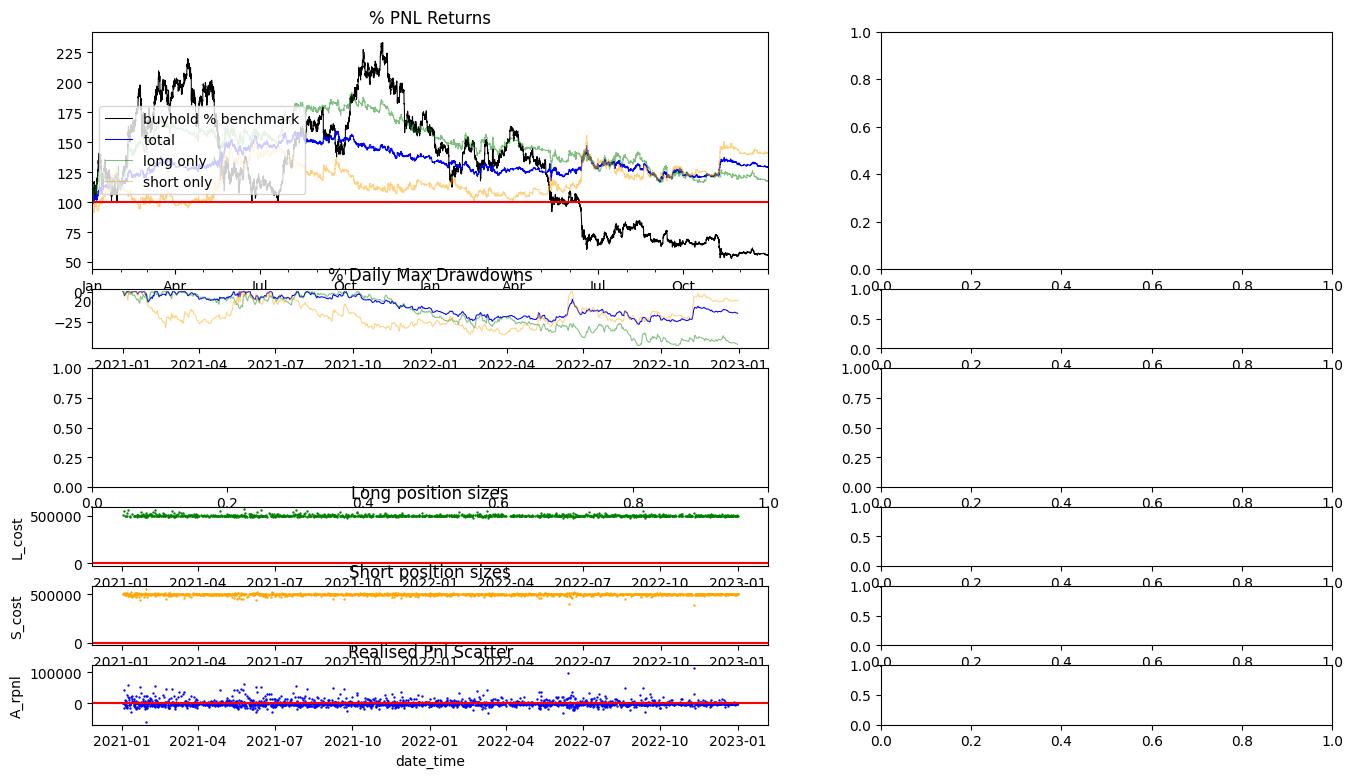

In [3]:
from performance_analytics.backtest_plot import backtest_plots, backtest_plots_simplified, backtest_plots_ppt 
df_backtested = best_df.copy()
df_summary = best_df_summary.copy()
backtest_plots(df_backtested,
                df_summary[["total", "longs only", "shorts only"]],
                horizon_labels=None,
                show_B = True, 
                title="Final Product",
                figsize=(16,9),
                fees = 0.0005)

# 3) RNN

## a) Load data

In [ ]:
from config.load_config import load_config_file
from main import Trading_Bot

import importlib
importlib.reload(Trading_Bot)


# Load model name from config-dev
MODEL_NAME = load_config_file('./config/config-dev.json')['model_name']
# Load model config from given model name in config-dev.json
model_config = load_config_file(f'./config/{MODEL_NAME}.json')

# bot = Trading_Bot.Trading_Bot(model_config)    





In [ ]:
from data_manager import klines_MR

klines_manager_mr = klines_MR.KlinesManagerMR(model_config)
instruments_dict = klines_manager_mr.load_and_update(limit_ccxt=1000, limit_TV=1000)

In [ ]:
# Resample from 1hr --> 2h, 3h, 4h, 6h, 12h, 24h, 
from signals import resampler

resample_to_list = ["2h", "3h", "4h", "6h", "12h", "24h"]
first_timeframe = "1h"

# resample_to_list = ["15m", "20m", "30m", "60m"]
# first_timeframe = "5m"
for instrument,instrument_dict in instruments_dict.items():
    print(f"\n{instrument}\n")
    for resample_to in resample_to_list:
        df = instrument_dict[first_timeframe].copy()
        window = int(int(resample_to[:-1])/int(first_timeframe[:-1]))
        print(f"Resampling {first_timeframe} to {resample_to} --> window: {window}")
        if "m" in resample_to:
            resample_to_formatted = resample_to[:-1]+"T"
        else:
            resample_to_formatted = resample_to
        df_resampled = resampler.calc_klines_resample(df,window=window, resample_to=resample_to_formatted)
        # print(df_resampled.columns)
        instruments_dict[instrument][resample_to] = df_resampled
        
    


## b) Calculate Signals

In [ ]:
import importlib
from signals import signals
importlib.reload(signals)
from signals import composite_signals
importlib.reload(composite_signals)

from signals import signal_thresholds
target_signal = "sig_close_US500"
z_apply_to = ["open_US500","high_US500","low_US500","close_US500", "volume_US500"]    
# z_apply_to = ["open","high","low","close","volume", "open_US500","high_US500","low_US500","close_US500", "volume_US500"]    
    
df_sigs_dict={} 
if first_timeframe == "1h":
    lookback_bars_x = 288
elif first_timeframe == "5m":
    lookback_bars_x = 288*12*5
for timeframe in list(instruments_dict[list(instruments_dict.keys())[0]].keys())[2:3]:
# timeframe = "1h"

    # print(f"Populating signals for {timeframe} ...")
    
    lookback_bars = lookback_bars_x/int(timeframe[:-1])
    print(f"\n\n{'='*40}\nPopulating signals for {timeframe}\nlookack: {lookback_bars}\n{'='*40}")

    instruments = list(instruments_dict.keys())    
    futures_trading_times = []
    z_lookback_windows = [lookback_bars]*len(z_apply_to)

    factors_to_compose = [] 
    factors_to_normalise = [] 
    temp = {}
    
    sig_dict0 = signals.merge_instruments_dict(instruments_dict = instruments_dict, 
                                              spot_instrument = instruments[0],
                                              futures_instruments = instruments[1], 
                                              futures_trading_times = futures_trading_times, #["02:30:00","10:00:00"],
                                              verbose = False)

    sig_dict0 = signals.populate_z_signals(sig_dict0,
                                          lookback_windows = z_lookback_windows, 
                                          sig_threshold = 2,
                                          columns = z_apply_to,
                                           verbose = True,
                                         )

    # sig_dict0 = composite_signals.calc_rolling_composite_signal(sig_dict0, 
    #                                                            factors_to_compose = factors_to_compose,
    #                                                            factors_to_normalise = factors_to_normalise,
    #                                                            test_factor_loadings =  None,#[-0.02178511, 0.99976268],
    #                                                            rolling_start_date = rolling_start_date,
    #                                                            rolling_window_period = rolling_window_period, 
    #                                                            min_period = min_period,
    #                                                            verbose=True)

    # fit window: 2020-01-02 06:00:00 --> 2020-12-31 21:55:00 
    # ===> 
    # sig0 pcs: [-0.02178511, 0.99976268] 
    # VS 
    # sig  pcs:[-0.02158948, 0.99976692]

    from signals import composite_signals
    importlib.reload(composite_signals)


    normalize=False



    # sig_dict = signal_thresholds.calc_signal_thresholds(sig_dict0,
    #                                                     normalize = normalize,
    #                                                     target_signal = target_signal,
    #                                                     threshold_func = "qtl",
    #                                                     L_q_lookback = L_q_lookback,
    #                                                     L_q_lower = L_q_lower,
    #                                                     S_q_lookback = S_q_lookback,
    #                                                     S_q_upper = S_q_upper,
    #                                                     S_q_lower = S_q_lower
    #                                                    )

    
    from signals import composite_signals
    importlib.reload(composite_signals) 

    df_sig = composite_signals.merge_signals(sig_dict0, smallest_timeframe = timeframe, target_signal = target_signal)
    # print(df_sig.columns)
    # %matplotlib widget

    # Select eigen vector with suitable signs [- and + ] but does doesnt tally for 2020-2021 where 0.05, 0.99
    # df_sig.filter(regex="weight").plot()


    import importlib
    from signals import position_sizing
    importlib.reload(position_sizing)

    instrument_atr = ""
    position_sizing_range = (1,2)

    df_sig = position_sizing.calc_position_sizes(df_sig,
                                                    high = f"{timeframe}_high{instrument_atr}",
                                                    low = f"{timeframe}_low{instrument_atr}",
                                                    close = f"{timeframe}_close{instrument_atr}",
                                                    window_ATR = 14,
                                                    window_norm=14,
                                                   newRange=position_sizing_range)

    df_sig.index.name = "date_time"

    df_sigs_dict[timeframe] = df_sig

## c) Label

In [ ]:
from labels import triple_barrier
import importlib
import numpy as np
importlib.reload(triple_barrier)

# df,labels_df = triple_barrier.calc_triple_barrier1(df_backtested, 
#                                                   col_series="5m_close", 
#                                                   col_timestamps="5m_close_time",
#                                                   horizon_delta = 5,
#                                                   upper_delta=0.001,
#                                                   lower_delta=-0.001, 
#                                                   labels=2)

# df = triple_barrier.calc_triple_barrier(df_backtested, 
#                                                   col_series="5m_close", 
#                                                   col_timestamps="5m_close_time",
#                                                   labels=3,
#                                                   fill_no_trades = False,
#                                                   horizon_delta = 5,
#                                                   vol_span = 144, 
#                                                   upper_z = 5, 
#                                                   lower_z = -5,
#                                                   upper_delta=0.01,
#                                                   lower_delta=-0.01)
# df[["label"]].hist()




def calc_labels(df0, 
                lookahead_window,
                threshold,
                labels=3,
                timeframe = "5m"):
    """ for each datetime, if next <<lookahead_window>> logreturns >0 then label is 1, else -1"""
    
    df = df0.copy()
    
    np_log_price = np.log(df[[f"{timeframe}_high", f"{timeframe}_low"]].mean(axis=1).values)
    np_close_time = df[f"{timeframe}_close_time"]
    # get midprice
    
    n = len(np_log_price)
    np_labels = np.full(n, np.nan)
    np_label_dates = np.full(n, np.nan)
    
    for i, t_seconds in enumerate(np_close_time):
        start_log_price = np_log_price[i]
        np_log_returns = np_log_price[i:i+lookahead_window] - start_log_price
        
        if labels == 2:
            if np_log_returns[-1] <threshold:
                label = -1
            else:
                label = 1
        elif labels == 3:
            if np_log_returns[-1] <-threshold:
                label = -1
            elif np_log_returns[-1] >threshold :
                label = 1
            else:
                label = 0
        np_labels[i] = label
    
    df["label"] = np_labels
    return df

###########################################
# Run labels
###########################################
timeframe = "3h"
number_of_labels=3
df = df_sigs_dict[timeframe].copy()
print(f"Columns before adding label: \n{df.columns}\n")
lookahead_window=19
threshold=0.025
df_labelled = calc_labels(df, labels=number_of_labels,lookahead_window=lookahead_window, threshold=threshold, timeframe=timeframe)

print(f"Columns after adding label: \n{df_labelled.columns}\n")

## d) Data Windowing

In [ ]:


import numpy as np
train_window = ["2020-10-01",'2021-09-30']
val_window = ["2021-10-01",'2021-12-31']
test_window = ['2022-01-01','2022-12-31']

# train_window = ["2020-04-01",'2021-03-30']
# val_window = ["2022-04-01",'2022-09-30']
# test_window = ['2022-10-01','2022-12-31']


# df=df.filter(regex="(1h)|(label)")
# df.dropna(inplace=True)
# df= df.filter(regex="(1h)|(label)")
df = df_labelled.copy()
timeframe = list(df.columns)[0].split("_")[0]
features = list(df.filter(regex="sig"))
cat_features = features
print(f"FEATURES: {features}")
#  Ensure cat_features are int

df[cat_features] = df[cat_features].fillna(method="ffill")
df.dropna(subset=cat_features,inplace=True)
df[cat_features]=df[cat_features].astype(int)
labels = ['label'] 

df_train = df[train_window[0]:train_window[1]].copy()
df_train_full = df[train_window[0]:val_window[1]].copy()
df_val = df[val_window[0]:val_window[1]].copy()
df_test = df[test_window[0]:test_window[1]].copy()

print(f"TOTAL window: {df.index[0]} ----> {df.index[-1]}, len: {len(df)}")
print(f"TRAIN window: {df_train.index[0]} ----> {df_train.index[-1]}, len: {len(df_train)}")
print(f"TOTAL TRAIN window: {df_train_full.index[0]} ----> {df_train_full.index[-1]}, len: {len(df_train_full)}")
print(f"VAL window: {df_val.index[0]} ----> {df_val.index[-1]}, len: {len(df_val)}")
print(f"TEST window: {df_test.index[0]} ----> {df_test.index[-1]}, len: {len(df_test)}")
print(f"VAL/TRAIN: {len(df_val)/(len(df_val)+len(df_train))}")
print(f"\ncat features:\n{cat_features}")
print(f"\nlabels:\n{labels}\nfeatures: \n{features}")


# %matplotlib widget
import matplotlib.pyplot as plt
fig, axs = plt.subplot_mosaic("AAA;BCD")
df_train[f"{timeframe}_close"].plot(ax=axs["A"])
df_val[f"{timeframe}_close"].plot(ax=axs["A"])
df_test[f"{timeframe}_close"].plot(ax=axs["A"])
df_train[labels].hist(ax=axs["B"], color="blue")
df_val[labels].hist(ax=axs["C"],color="orange")
df_test[labels].hist(ax=axs["D"],color="green")
# df[test_window[1]:][labels].hist(ax=axs["D"],color="green")
# label_train = df_train[labels].value_counts()


# 

In [ ]:
# Rescale the features
from sklearn.preprocessing import StandardScaler  # MinMaxScaler

# train_features = df_train[features]
# train_labels = df_train[labels]

# test_features = df_test[features]
# test_labels =  df_test[labels]

# scaler = StandardScaler()  # MinMaxScaler(feature_range=(-1,1))
# scaled_train_features = pd.DataFrame(scaler.fit_transform(train_features.values),
#                                      index=train_features.index,
#                                      columns=train_features.columns)
# # The Scaler is fit on the training set and then applied to the test set
# scaled_test_features = pd.DataFrame(scaler.transform(test_features.values),
#                                     index=test_features.index,
#                                     columns=test_features.columns)



x_train = df_train[features].values
x_val = df_val[features].values
x_test = df_test[features].values

y_train = df_train[labels].values
y_val = df_val[labels].values
y_test = df_test[labels].values

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
# Change to 2 labels

if number_of_labels >2:
    y_train = y_train +1
    y_val = y_val +1
    y_test = y_test+1
else:  
    y_train[y_train == -1] = 0
    y_val[y_val == -1] = 0
    y_test[y_test == -1] = 0

print(f"x_train shape: {x_train.shape}\ny_train shape: {y_train.shape}\n")
print(f"x_val shape: {x_val.shape}\ny_val shape: {y_val.shape}\n")
print(f"x_test_shape : {x_test.shape}\ny_test_shape : {y_test.shape}\n")
print(f"y_train labels: {np.unique(y_train)}\ny_val labels: {np.unique(y_val)}\ny_test labels: {np.unique(y_test)}")

## e) Build Model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    number_of_labels,
    input_shape, # Number of features
    transformer_params,
    mlp_units,
    lstm_units=[10],
    dropout=0,
    mlp_dropout=0,
):
    
                    
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    # -------------
    # transformer layers
    # -------------
    num_transformer_blocks=transformer_params["num_transformer_blocks"]
    head_size=transformer_params["head_size"]
    num_heads=transformer_params["num_heads"]
    ff_dim=transformer_params["ff_dim"]
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    
    # -------------
    # LSTM
    # -------------
    # for dim in lstm_units: 
    #     x = layers.LSTM(dim, activation="tanh",recurrent_activation="sigmoid")(x)
    
    # -------------
    # dense layers
    # -------------
    for dim in mlp_units:
        x = layers.Dense(dim, activation="tanh")(x)
        # x = layers.Dropout(mlp_dropout)(x)
        
    
    
    
    outputs = layers.Dense(number_of_labels, activation="softmax")(x)
    return keras.Model(inputs, outputs)


##################################################################
# BUILD MODEL
##################################################################
transformer_params = {"num_transformer_blocks":0,
                      "num_heads":4,
                      "head_size":256,
                      "ff_dim":4,
                     }

mlp_units=[128]
mlp_dropout=0.2
dropout=0.25
epochs=1000
batch_size = 96

model = build_model(
                    number_of_labels=number_of_labels,
                    input_shape=x_train.shape[1:],
                    transformer_params = transformer_params,
                    mlp_units=mlp_units,
                    mlp_dropout=mlp_dropout,
                    dropout=dropout,
                    )

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

### i) Run model

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss",patience=20, restore_best_weights=True)]
# callbacks = []

history = model.fit(
                    x_train,
                    y_train,
                    validation_data = (x_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size, # Try for different batch sizes, past 64 hours good enough???
                    callbacks=callbacks,
                )

#  EVALUATE

# Evaluate the model:
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=1)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)




In [ ]:
print(f"\n\n{'-'*65}\nModel Performance\n{'-'*65}\n")
print(f'train accuracy = {round(train_acc * 100, 2)}%')
print(f'test accuracy = {round(test_acc * 100, 2)}%')
print(f'test error = {round((1 - test_acc) * x_test.shape[0])} out of {x_test.shape[0]} examples')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axs[0].plot(history.history['loss'], color='b', label='Training loss')
axs[0].plot(history.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(history.history['sparse_categorical_accuracy'], color='b', label='Training accuracy')
axs[1].plot(history.history['val_sparse_categorical_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

### ii) Model Performance

In [ ]:



# pred = model.predict(x_test, verbose=1)
df_to_backtest = df[train_window[0]:].copy()
x_backtest = df_to_backtest[features].values
x_backtest = x_backtest.reshape((x_backtest.shape[0], x_backtest.shape[1], 1))

pred = model.predict(x_backtest)
if number_of_labels > 2:
    df_to_backtest["p_u"] = pred[:,2]
    df_to_backtest["p_s"] = pred[:,1]
    df_to_backtest["p_d"] = pred[:,0]
else:
    df_to_backtest["p_u"] = pred[:,1]
    df_to_backtest["p_d"] = pred[:,0]
    df_to_backtest["p"] = pred[:,1]

# df_to_backtest["Y"] = 




# 2) Perform genetic optimizer and plot macro tides

In [ ]:
from signal_managers import tide_genetic

tp_position_list = tide_genetic.init_tp_position_parameter_population()
df0 = tide_genetic.initialise_parent(df, signal_function = "strength_w_macros")
tide_parameters_to_test = {"sensitivity":40,
                           "threshold":10,
                            "windows":[24,36,72],
                            "SL_penalty":1,
                            "TPs": tp_position_list[0],
                           }
sharpe_df, best_df, best_parameter,  = tide_genetic.evaluate_population(df0,parameters = tide_parameters_to_test, generations=20)

In [ ]:
import pandas as pd
tide_macros_df = {}
for i in range(len(df)):
    tide_macros_df[i] = df[macro_features_selected].iloc[i,:].fillna(0).mean()

In [ ]:
tide_macros_df

In [ ]:
tide_macros_df = pd.DataFrame.from_dict(tide_macros_df, orient='index', columns=['Value'])
tide_macros_df

4) GNN
We know that certain parameters give certain optimal sharpes. We can use ML to train a model to predict for future tide

In [ ]:
from klines_managers import klines_ccxt

instruments =  ["ccxt_kucoin__BTC-USDT"]
timeframes = ["1h"]

label = 'label'


kline_manager = klines_ccxt.KlinesManagerCCXT()
test = kline_manager.load_ohlcvs(instruments = instruments,
                                    timeframes = timeframes,
                                    since = "2020-01-01 00:00:00",
                                    limit = 1000, update=False)

from signal_managers import indicators
df = test["ccxt_kucoin__BTC-USDT"]["1h"].copy()
df = indicators.calc_tides(df,suffix="")
df=df.dropna()
from signal_managers import tide_genetic

tp_position_list = tide_genetic.init_tp_position_parameter_population()
df0 = tide_genetic.initialise_parent(df)
df0 = calc_tide_strengths(df0, penalty = 1, tp_position_dict = tp_position_list[0])
features = ['tide', 'ebb', 'flow', 'sig'] + list(df0.copy().filter(regex="tide").columns)[:-1]
features = list(set(features))

tide_parameters_to_test = {"sensitivity":40,
                           "threshold":10,
                            "windows":[24,36,72],
                            "SL_penalty":1,
                            "TPs": tp_position_list[0],
                           }
sharpe_df, best_df, best_parameter = tide_genetic.evaluate_population(df0,parameters = tide_parameters_to_test, generations=10)

best_df[features].fillna(method='ffill').dropna(inplace=True)
from utils import pickle_helper
# df = pickle_helper.pickle_this(pickle_name= "debugdf_backtested", path = "./backtesters/")
# df = pickle_helper.pickle_this(pickle_name = "df_backtest_debugging", path = "./backtesters/debug/")
# df.rename(columns={"tide_fast":"tide", "ebb_fast":"ebb", "flow_fast":"flow"}, inplace=True)

# THis assumes backtest 1 have been done 
from signal_managers.indicators import calc_tide_strengths


df = indicators.calc_tides(best_df)
df = calc_tide_strengths(df, penalty = 1, tp_position_dict = tp_position_dict)
df['label'] = df['tide'].shift(-1).fillna(method='ffill')

## a) Build a model to predict the tide of btc

### i) Catboost 

In [ ]:
1900/3

### ii) GMM

In [ ]:
import numpy as np

lookback = 24

def build_adj_node_relationship(num_nodes = 3):

    # Define the number of nodes in the graph.

    # Initialize the adjacency matrix with zeros.
    adj_matrix = np.ones((num_nodes, 1))

    # Add edges to the adjacency matrix.
    # For an undirected graph, the adjacency matrix is symmetric.
    return adj_matrix

In [ ]:
# pip install torch
# pip install torch_geometric
# pip install sklearn
# pip install keras-gcn

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from keras_gcn import GraphConv
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

class MyLayer(tf.keras.layers.Layer):

  def build(self, input_shape):
    # Set the dtype to float32.
    self.dtype = tf.float32

# Define the GNN model.
class GNN(tf.keras.Model):
    def __init__(self, num_features, num_classes):
        super(GNN, self).__init__()
        self.graph_conv = GraphConv(64)
        self.dense = Dense(num_classes)

    def call(self, inputs):
        features, graph = inputs
        x = self.graph_conv(features, graph)
        x = tf.nn.relu(x)
        # Set the first element of the array to 1.
        x = tf.assign(x[:, 0], 1)
        x = tf.reshape(x, (-1, 1, 81))
        x = self.dense(x)
        return x

# Load and preprocess the data.
# Make sure to define the variables `features`, `df`, and `adj_matrix` before using them.
num_features = len(features)
encoder = LabelEncoder()
df1 = df[features+["label"]].fillna(method='ffill').dropna()
dataset_train, dataset_test = train_test_split(df1, test_size=0.2)
x_train = dataset_train[features].dropna().values
y_train = dataset_train['label'].values
y_train_encoded = encoder.fit_transform(y_train)
x_test = dataset_test[features].dropna().values
y_test = dataset_test['label'].values
y_test_encoded = encoder.transform(y_test)

# Create and compile the GNN model.
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.run_eagerly = True

model.compile(optimizer='adam', loss=binary_crossentropy, metrics=['accuracy', 'auc'])
model.build(input_shape=np.shape(x_train.astype('float32')))
# Fit the GNN model to the training data.
# The `x_train` array now has an extra dimension at the beginning and the first element is 1.
adj_matrix = build_adj_node_relationship(len(x_train))
print(model)

model.fit((x_train, adj_matrix), y_train_encoded, epochs=10, batch_size=128)
# Evaluate the GNN model on the test data.
# model.evaluate((x_test.astype('float32'), adj_matrix), y_test_encoded)


In [ ]:
model.summary()

In [ ]:
np.shape(x_train.astype('float32'))

In [ ]:
print(np.shape(x_train.astype('float32')))
print(np.shape(adj_matrix))
print(np.shape(y_train_encoded))

In [ ]:
np.shape(x_train.astype('float32'))

In [ ]:
for item in features:
    if item not in list(dataset_train[features].columns):
        print(item)

In [ ]:
features

In [ ]:
len(set(list(dataset_train[features].columns)))

In [ ]:
df["tide_short_strength_t"].dropna()